In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

Tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


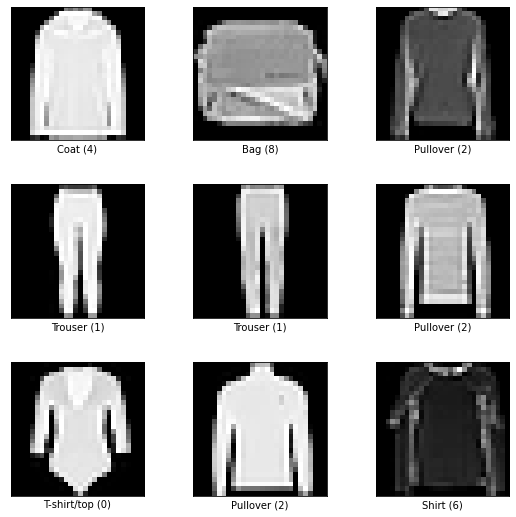

In [3]:
dataset_name = 'fashion_mnist' #mnist
ds_train, ds_info = tfds.load(dataset_name, split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)

In [4]:
batch_size = 400
global_batch_size = batch_size *  1
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    label = features['label']
    return image, label


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(global_batch_size).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

150


In [18]:
class cDCGAN():
    def __init__(self, input_shape):
        self.z_dim = 100
        self.input_shape = input_shape
        self.num_classes = 10
        # discriminator
        self.n_discriminator = 1     
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = False
        self.optimizer_discriminator = RMSprop(1e-4)
                
        # build generator pipeline with frozen discriminator
        self.generator = self.build_generator()
        discriminator_output = self.discriminator([self.generator.output, self.generator.input[1]])
        self.model = Model(self.generator.input, discriminator_output)
        self.model.compile(loss = self.bce_loss,
                           optimizer = RMSprop(1e-4))
        self.discriminator.trainable = True
        self.bce = tf.keras.losses.BinaryCrossentropy()

    def conv_block(self, channels, kernels, strides=1, 
                   batchnorm=True, activation=True):
        model = tf.keras.Sequential()
        
        model.add(layers.Conv2D(channels, kernels, strides=strides, padding='same'))
        if batchnorm:
            model.add(layers.BatchNormalization())              
        if activation:
            model.add(layers.LeakyReLU(0.2)) 
                  
        return model
    
    def bce_loss(self, y_true, y_pred):

        loss = self.bce(y_true, y_pred)

        return loss

    def build_generator(self):

        DIM = 128
        
        input_label = layers.Input(shape=1, dtype=tf.int32, name='ClassLabel')
        
        one_hot_label = tf.one_hot(input_label, self.num_classes)
        one_hot_label = layers.Reshape((self.num_classes,))(one_hot_label)
         
        input_z = layers.Input(shape=self.z_dim, name='LatentVector')
        x = layers.Concatenate()([input_z, one_hot_label])
        x = layers.Dense(4*4*4*DIM, activation=None)(x)
        x = layers.Reshape((4,4,4*DIM))(x)

        x = layers.UpSampling2D((2,2), interpolation="bilinear")(x)
        x = self.conv_block(2*DIM, 5)(x)

        x = layers.UpSampling2D((2,2), interpolation="bilinear")(x)
        x = self.conv_block(DIM, 5)(x)

        x = layers.UpSampling2D((2,2), interpolation="bilinear")(x)
        output = layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')(x)
    

        return Model([input_z, input_label], output)                 
    

    def build_discriminator(self):
        DIM = 128
        
        # label
        input_label = layers.Input(shape=[1], dtype =tf.int32, name='ClassLabel')
        
        embedding = layers.Embedding(self.num_classes, 32*32*1)(input_label)
        embedding = layers.Reshape((32, 32, 1))(embedding)
          
        # discriminator
        input_image = layers.Input(shape=self.input_shape, name='Image')
        x = layers.Multiply()([input_image, embedding])
        x = self.conv_block(DIM, 5, 2, batchnorm=False)(x)
        x = self.conv_block(2*DIM, 5, 2)(x)
        x = self.conv_block(4*DIM, 5, 2)(x)
        x = layers.Flatten()(x)

        output = layers.Dense(1, activation='sigmoid')(x)
        return Model([input_image, input_label], output)         
    
    def train_discriminator(self, real_images, class_labels, batch_size):
        real_labels = tf.ones(batch_size)
        fake_labels = tf.zeros(batch_size)
                  
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_class_labels = tf.random.uniform((batch_size,1), minval=0, maxval=10, dtype=tf.dtypes.int32)
        fake_images = self.generator.predict([g_input, fake_class_labels])
        
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([fake_images, fake_class_labels])
            pred_real = self.discriminator([real_images, class_labels])
            
            # calculate losses
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)           
            
            # total loss
            total_loss = 0.5*(loss_fake + loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return loss_fake, loss_real
    
    def train(self, data_generator, batch_size, steps, interval=100):
        
        val_g_input = tf.random.normal((self.num_classes, self.z_dim))
        val_class_labels = np.arange(self.num_classes)
        real_labels = tf.ones(batch_size)
        
        for i in range(steps):
    
            real_images, class_labels = next(data_generator)
            loss_fake, loss_real = self.train_discriminator(real_images, class_labels, batch_size)
            discriminator_loss = 0.5*(loss_fake + loss_real)
                
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            fake_class_labels = tf.random.uniform((batch_size, 1), 
                                         minval=0, maxval=self.num_classes, dtype=tf.dtypes.int32)
            g_loss = self.model.train_on_batch([g_input, fake_class_labels], real_labels)
            if i%interval == 0:
                msg = "Step {}: discriminator_loss {:.4f} g_loss {:.4f}"\
                .format(i, discriminator_loss, g_loss)
                print(msg)
                
                fake_images = self.generator.predict([val_g_input,val_class_labels])
                self.plot_images(fake_images)
            
    def plot_images(self, images):   
        grid_row = 1
        grid_col = 10
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)/2, cmap='gray')
            axarr[col].axis('off') 
        plt.show()
        
    def sample_images(self, class_labels):
        z = tf.random.normal((len(class_labels), self.z_dim))
        images = self.generator.predict([z,class_labels])
        self.plot_images(images)
        return images
    


In [19]:
cdcgan = cDCGAN(image_shape)

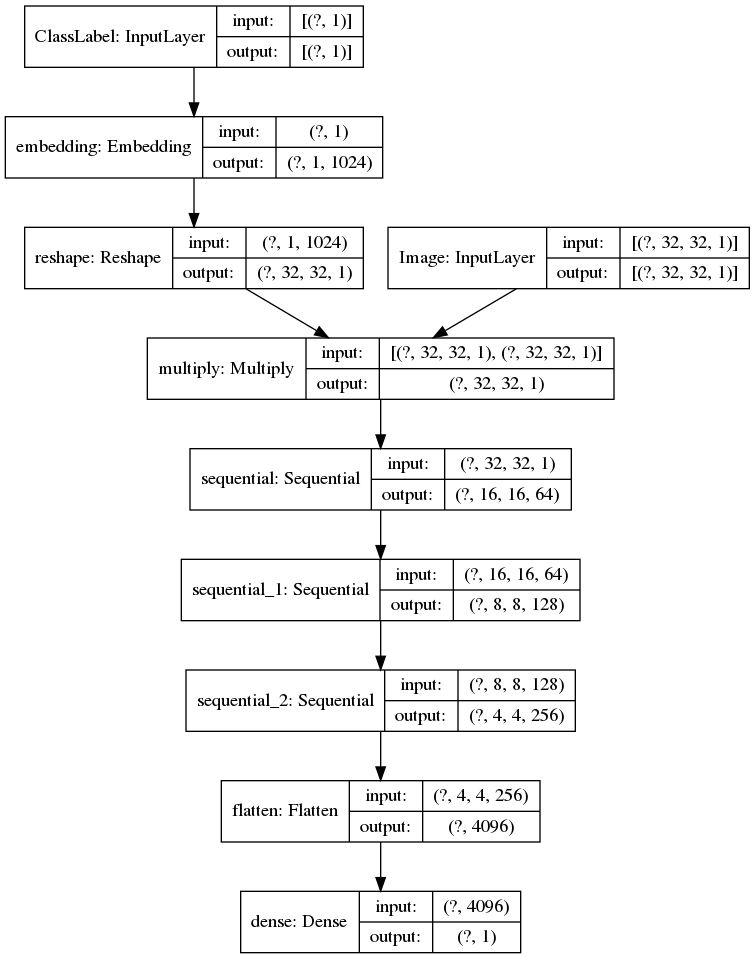

In [7]:
tf.keras.utils.plot_model(cdcgan.discriminator, show_shapes=True)

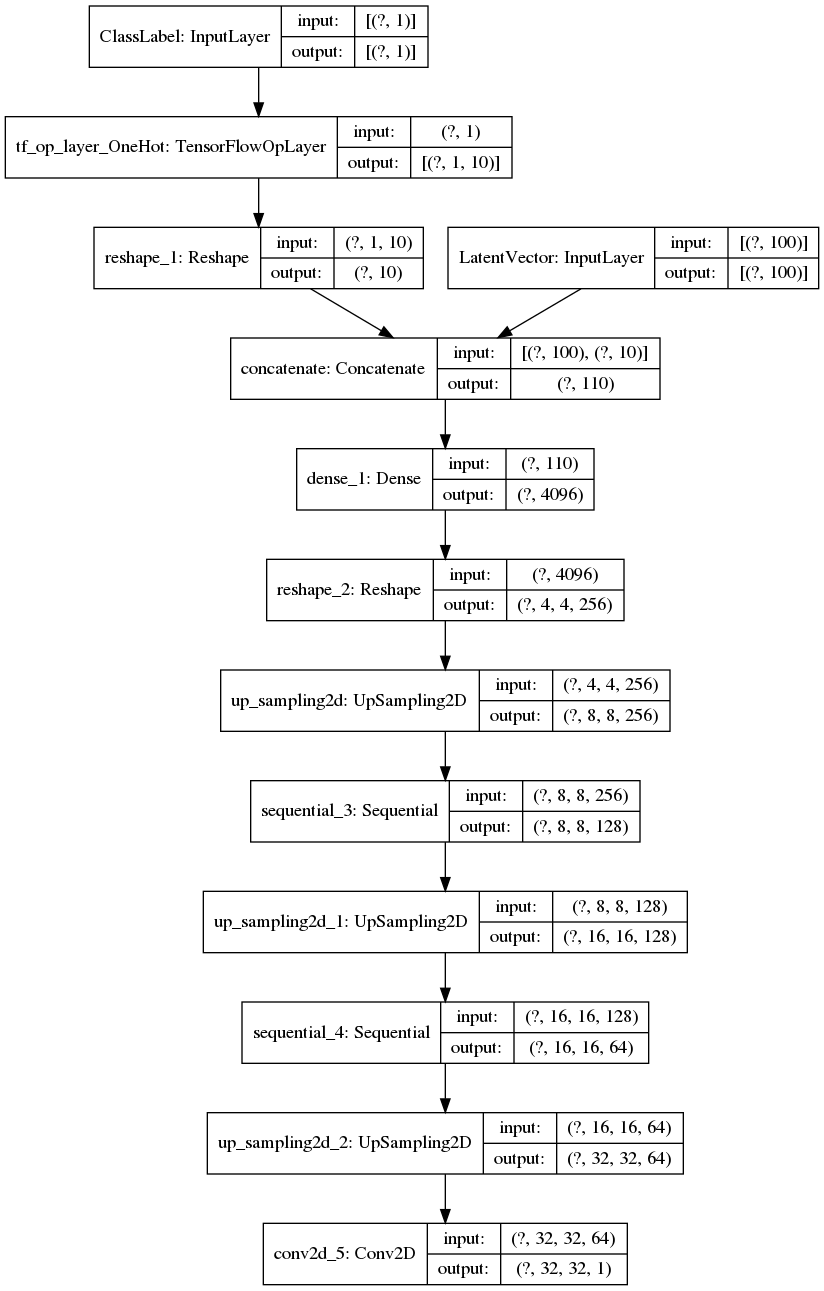

In [8]:
tf.keras.utils.plot_model(cdcgan.generator, show_shapes=True)

Step 0: discriminator_loss 0.6931 g_loss 0.6866


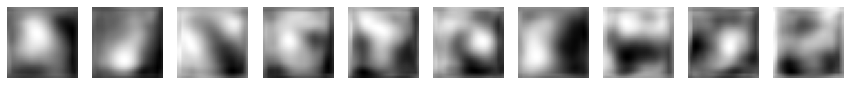

Step 200: discriminator_loss 0.0413 g_loss 0.0000


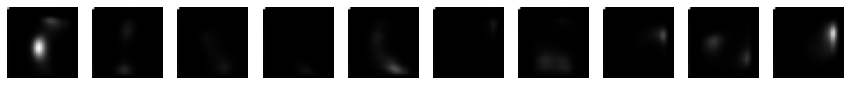

Step 400: discriminator_loss 0.6819 g_loss 0.6756


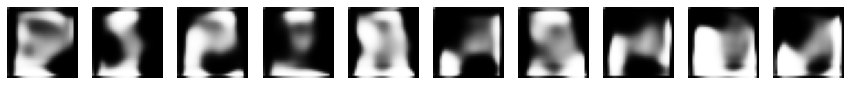

Step 600: discriminator_loss 0.6937 g_loss 0.6923


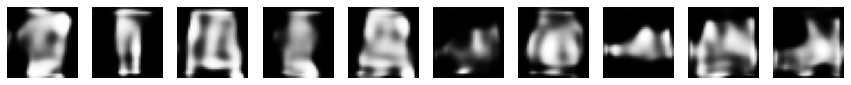

Step 800: discriminator_loss 0.6919 g_loss 0.6901


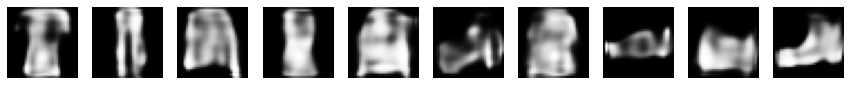

Step 1000: discriminator_loss 0.6917 g_loss 0.7015


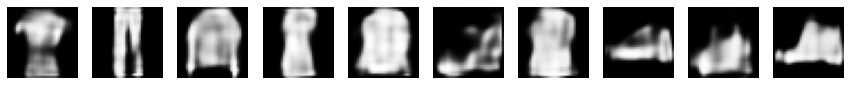

Step 1200: discriminator_loss 0.6882 g_loss 0.7039


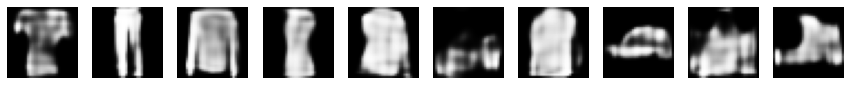

Step 1400: discriminator_loss 0.6894 g_loss 0.7294


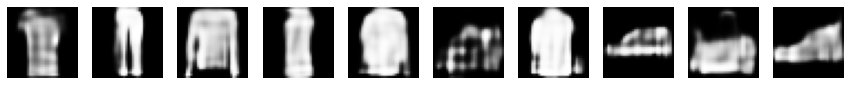

Step 1600: discriminator_loss 0.6876 g_loss 0.6913


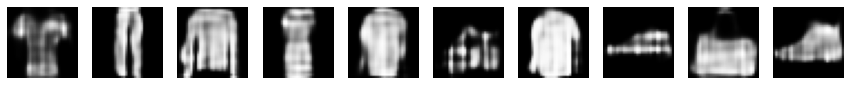

Step 1800: discriminator_loss 0.6855 g_loss 0.6964


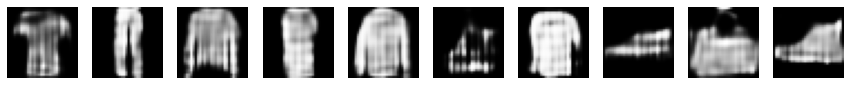

Step 2000: discriminator_loss 0.6786 g_loss 0.7735


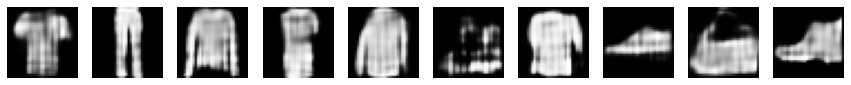

Step 2200: discriminator_loss 0.6711 g_loss 0.7164


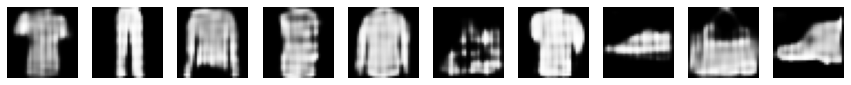

Step 2400: discriminator_loss 0.6685 g_loss 0.7670


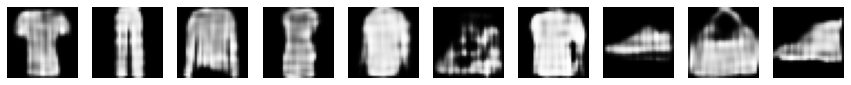

Step 2600: discriminator_loss 0.6722 g_loss 0.7473


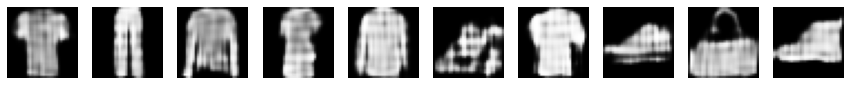

Step 2800: discriminator_loss 0.6555 g_loss 0.7296


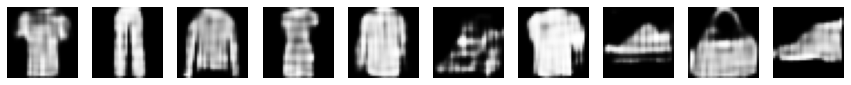

Step 3000: discriminator_loss 0.6647 g_loss 0.8520


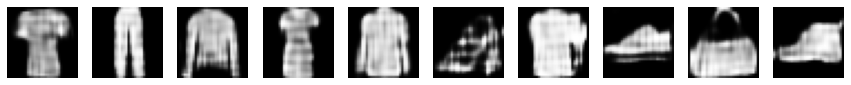

Step 3200: discriminator_loss 0.6664 g_loss 0.8647


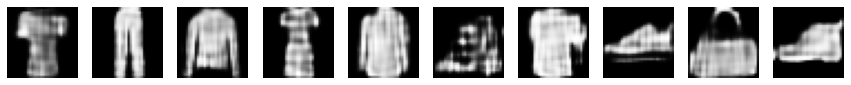

Step 3400: discriminator_loss 0.6445 g_loss 0.8348


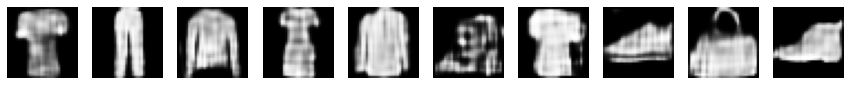

Step 3600: discriminator_loss 0.6487 g_loss 0.7037


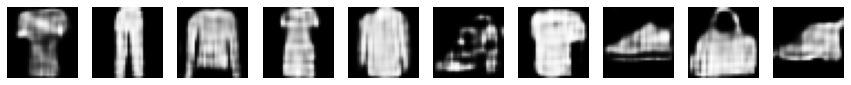

Step 3800: discriminator_loss 0.6407 g_loss 0.6887


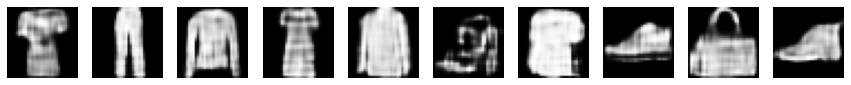

Step 4000: discriminator_loss 0.6339 g_loss 0.8262


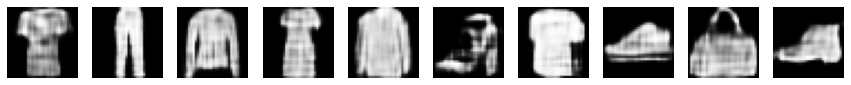

Step 4200: discriminator_loss 0.6648 g_loss 0.8126


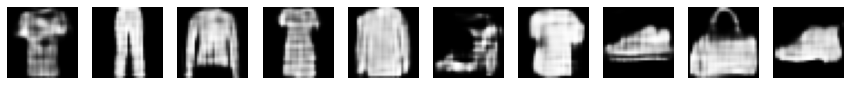

Step 4400: discriminator_loss 0.6295 g_loss 0.8791


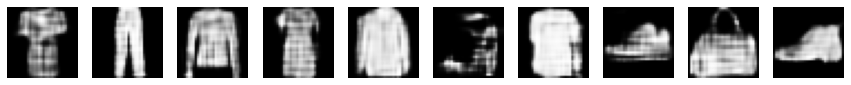

Step 4600: discriminator_loss 0.6428 g_loss 0.8050


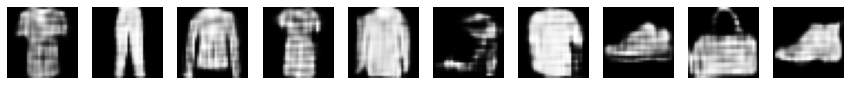

Step 4800: discriminator_loss 0.6442 g_loss 0.7285


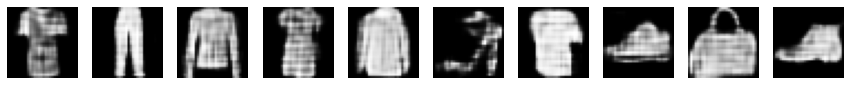

In [20]:
cdcgan.train(iter(ds_train), batch_size, 5000, 200)

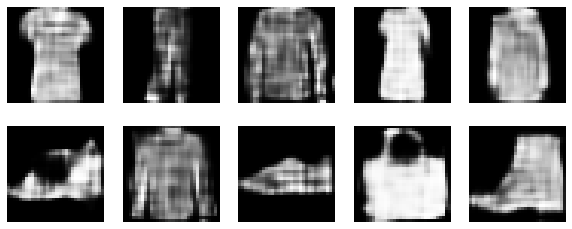

In [17]:
class_labels = np.array([0,1,2,3,4,5,6,7,8,9])
z = tf.random.normal((len(class_labels), cdcgan.z_dim))
images = cdcgan.generator.predict([z, class_labels])
grid_row = 2
grid_col = 5
f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2, grid_row*2))
i=0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row][col].imshow((images[i,:,:,0]+1)/2, cmap='gray')
        axarr[row][col].axis('off') 
        i+=1
plt.show()
